<h1 style="text-align:center"> BUZZ SOLUTIONS CODING CHALLENGE</h1>
<h1 style="text-align:center"> MNIST Dataset Classification with CNN and tensorflow</h1>

# GOAL OF THE PROJECT
> Classifying images of MNIST dataset using CNN and tensorflow.

## Contents in this notebook:-

1) [Loading Data](#loading_data)
   - [Libraries used](#libraries)
   - [Input Data](#input)
   
2) [CNN](#CNN)
   - [Idea](#i)
   - [Weigths and Bias Initilization.](#wb_init)
   - [Configuration of Neural Network](#config)
   - [Parameters](#param)
   - [Convolution layer Function](#fun_con)
   - [Flattening layer Function](#fun_flat)
   - [Full connected Layer Function](#fun_full)
   - [CNN Architecture](#arc)
   - [Number of Parameters](#no_para)

3) [Training and Testing Network](#tt)
   - [Testing and Evaluation Function](#acc)
   - [Training Pipeline and Function (includes tf.InteractiveSession())](#fun_train)
   - [Sanity Check](#Sanity_Check)
   - [Overfitting](#over)
   - [Training on full data](#full)
   
4) [Tensorboard Visualizations (Loss, Accuracy Curves and Model)](#tensor)
   
5) [Visualizing Layers and Weights](#vis)
   - [Layer 1](#l1)
   - [Layer 2](#l2)
   
6) [Problems Faced](#prob)

7) [How to overcome them](#how)

<a id='loading_data'></a>
## Loading MNIST Data in TensorFlow

In [191]:
%load_ext pycodestyle_magic 
# In order to make code look neat and understandable I used "pycodestyle extension"

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


<a id='libraries'> </a>
- Libraries

In [190]:
# %%pycodestyle # It has to be commented for the code to run

# Libraries used
import tensorflow as tf
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import math

<a id='input'> </a>
- Input Data

In [3]:
# %%pycodestyle

# Data from tensorflow examples

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Training, Testing, Validation Sets
X_train, y_train = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

- Shapes and Lengths of Input Data.

In [6]:
# %%pycodestyle

print("Image Shape:    {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {}  samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape:    (784,)
Training Set:   55000 samples
Validation Set: 5000  samples
Test Set:       10000 samples


<a id='CNN'></a>
## CNN implementation

<a id='i'></a>
### IDEA:-

> At first I thought of implementing transfer learning in MNIST using keras taking 5,6,7,8,9 labels as my input and then freeze the layers except for the last layer and give the input as 0,1,2,3,4 labels which yields a state of the art performance about 99.6% on the 0-4 labelled dataset despite training on 5-9 data. But then given the cpu/gpu constrains and time I decided to implement a traditional neural network as follows,

**Why CNN?**

CNNs work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the CNN much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the CNNs faster to train.

<a id='wb_init'></a>
- Weigths and Bias Initilization.

**Reason to opt Xavier initialization over truncated normal initialization:-**
> 1) In a recent paper I read (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), there are few suspects for exploding gradients and vanishing gradients problem as mentioned by xavier in that paper.

> 2) The problem was with sigmoid activation and normal initialization of weights, the variance of the outputs of each layer is greater than variance of inputs. Going forward, variance keeps increasing after each layer until the activation function saturates at the top layers.

> 3) For the signal to flow properly instead of exploding or saturating we need the variance of outputs of each layer to be equal to variance of inputs. And we also need gradients to have equal variance before and after propagating.

> 4) This is actually not possible to guarentee both but they provided a good compromise in the paper with weight initialization. The Xavier initialization is as follows.

In [8]:
# %%pycodestyle

# Functions for weigths and bias initilization 
def weight_variable(shape, name="Weights"):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=name)

def bias_variable(shape, name="Biases"):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=name)

<a id='config'></a>
- Configuration of Neural Network

In [9]:
tf.reset_default_graph() # reset the default graph before defining a new model

In [110]:
# %%pycodestyle

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 6          # There are 6 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 16         # There are 36 of these filters.

# Fully-connected layer 1.
fc_size1 = 120            # Number of neurons in fully-connected layer. 

# Fully-connected layer 2.
fc_size2 = 84             # Number of neurons in fully-connected layer.

In [11]:
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

<a id='param'></a>
- Traning parameters

Unlike selecting the learning rate value randomly. The train function is first ran with 1e-5 learning rate and then  I progressed to 1e-3 where I found the loss is going down. All of this is done in [Sanity check](#Sanity_Check).

In [12]:
learning_rate = 0.001  # The optimal range to choose learning rate is [1e-5,1e-3].
training_epochs = 40   # Number epochs is the training.
batch_size = 128       # Number of samples that going to be propagated through the network.
small_batch_size=64    # Number of samples that going to be propagated through the network.
logs_path = 'log_files/'  # File directory to save or visualize neural network in Tensorboard.

**Reason to use ELU over RELU:-**
> 1) (https://arxiv.org/pdf/1511.07289.pdf) From this paper which emphasizes on activation functions. I found that ELUs are better than RELUs.

> 2) ReLUs doesn't saturate for positive values and is fast compared to sigmoid. But it isn't perfect. It suffers from something called <i>Dying ReLUs</i>. To solve this problem there are some advancements made for ReLU called LeakyReLU, PReLU, ELU.

> 3) Coming to ELUs, It takes on negative values when the input is less than zero, which allows unit to have an output closer to zero, which helps us to solve vanishing gradients problem.

> 4) It has non zero gradients for negative values which avoids dying units issue.

> 5) The function is smooth everywhere including when the input is zero, which helps speeds up gradient descent a little bit

<a id='fun_con'></a>
### Function to create a new Convolutional Layer

In [13]:
# %%pycodestyle

def convolution_layer(input,              # The previous layer.
                      num_input_channels, # Num. channels in prev. layer.
                      filter_size,        # Width and height of each filter.
                      num_filters,        # Number of filters.
                      name_weights,
                      name_biases,
                      name_layer,
                      use_pooling=True,
                      use_padding=True):  # Use 2x2 max-pooling.  
    
    """This function creates a new convolutional layer in the 
    computational graph for TensorFlow. Nothing is actually calculated here, 
    we are just adding the mathematical formulas to the TensorFlow graph."""
    
        # Input is assumed to be a 4 dimensional tensor with the following dimensions:
        # 1. Image number.
        # 2. Y-axis of each image.
        # 3. X-axis of each image.
        # 4. Channels of each image.
    
    with tf.name_scope(name_layer):
        
        # Shape of the filter weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights (called filters in tensorflow) with the given shape.
        weights = weight_variable(shape=shape, name=name_weights)

        # Create new biases, one for each filter.
        biases = bias_variable(shape=[num_filters], name=name_biases)

        # TensorFlow operation for convolution.
        # The first and last stride must always be 1,
        # because the first is for the image number and
        # the last is for the input-channel.
        
        # strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x and y axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        if use_padding:
            layer = tf.nn.conv2d(input=input,
                                 filter=weights,
                                 strides=[1, 1, 1, 1],
                                 padding='SAME')
        else: 
            layer = tf.nn.conv2d(input=input,
                                 filter=weights,
                                 strides=[1, 1, 1, 1],
                                 padding='VALID')

        # Adding biases to the results of the convolution.
        # A bias value is added to each filter-channel.
        layer += biases

        # Used pooling to downsample the image resolution
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer, 
                                   ksize=[1, 2, 2, 1], 
                                   strides=[1, 2, 2, 1], 
                                   padding='SAME')

        # Exponential Linear Unit (ELU).
        # It computes exp(features) - 1 if < 0, features otherwise.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.elu(layer, name=name_layer)

        # I return both the resulting layer and the filter weights
        # to plot the weights later.
    return layer, weights

<a id='fun_flat'></a>
### Function for Flattening a layer

In [14]:
# %%pycodestyle

def flatten_layer(layer):
    
    """A convolutional layer produces an output tensor with 4 dimensions. 
    We will add fully-connected layers after the convolution layers, 
    so we need to reduce the 4-dim tensor to 2-dim which can be used
    as input to the fully-connected layer."""
    
    with tf.name_scope("flatten_layer"):
        # Get the shape of the input layer.
        layer_shape = layer.get_shape()

        # The shape of the input layer is assumed to be:
        # layer_shape == [num_images, img_height, img_width, num_channels]

        # The number of features is: img_height * img_width * num_channels
        num_features = layer_shape[1:4].num_elements()

        # Reshaping the layer to [num_images, num_features].
        # I set the size of the second dimension to
        # num_features and the size of the first dimension to -1
        # which means the size in that dimension is calculated
        # so the total size of the tensor is unchanged from the reshaping.
        layer_flat = tf.reshape(layer, [-1, num_features],name="flatten_layer")

        # The layer is flattened with the dimensions below
        # [num_images, img_height * img_width * num_channels]

    return layer_flat, num_features

<a id='fun_full'></a>
### Function for creating a Fully-Connected Layer

In [15]:
# %%pycodestyle

def fc_layer(input,           # The previous layer.
             num_inputs,      # Num. inputs from prev. layer.
             num_outputs,     # Num. outputs.
             name_layer,
             use_elu=True):   # Use Exponential Linear Unit (ELU)
    
    """Just like in creating convolutional layer function,
    This function creates a new fully-connected layer 
    in the computational graph for TensorFlow. 
    Nothing is actually calculated here, we are just adding the 
    mathematical formulas to the TensorFlow graph."""
    
        # The input is a 2-dim tensor of shape [num_images, num_inputs]. 
        # The output is a 2-dim tensor of shape [num_images, num_outputs].
    
    with tf.name_scope(name_layer):
        
        # In tensorflow the weights are also known as filters.
        # weights are created from weight_variable function.
        weights = weight_variable(shape=[num_inputs, num_outputs])

        # Biases, one for each filter from bias_variable function.
        biases = bias_variable(shape=[num_outputs])

        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases

        if use_elu:
            layer = tf.nn.elu(layer, name=name_layer)

    return layer

<a id='arc'></a>
## CNN architecture


- My architecture takes a 28x28x1 image as input.


- Layer 1 - 
            Convolution (5x5): The output shape should be 28x28x6. 
            Activation: ELU.  
            MaxPooling: The output shape should be 14x14x6.

- Layer 2 - 
            Convolution (5x5): The output shape should be 10x10x16. 
            Activation: ELU. 
            MaxPooling: The output shape should be 5x5x16.

- Flatten: 
            Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

- Layer 3 - 
            Fully Connected: This should have 120 outputs. 
            Activation: ELU.

- Layer 4 - 
            Fully Connected: This should have 84 outputs. 
            Activation: ELU.

- Layer 5 - 
            Fully Connected: This should have 10 outputs. 
            Activation: softmax.

In [16]:
# %%pycodestyle

def CNN_architecture(drop_out=False): 

    """CNN architecture."""
    
    # Placeholder variable for the input images
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
    # print("x_shape",tf.shape(x))
    # The convolutional layers expect x to be encoded as a 4-dim tensor so it has to be reshaped
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels],name="x_image")
    # Placeholder variable for the true labels 
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    # print("y_shape",tf.shape(y_true))
    # placeholder variable for the class-number
    y_true_cls = tf.argmax(y_true, axis=1, name="y_true_cls")
    
    #Convolutional Layer 1
    layer_conv1, weights_conv1 = convolution_layer(input=x_image,
                                                   num_input_channels=num_channels,
                                                   filter_size=filter_size1,
                                                   num_filters=num_filters1,
                                                   name_weights= "weights_conv1",
                                                   name_biases="biases_conv1",
                                                   name_layer="layer_conv1",
                                                   use_pooling=True,
                                                   use_padding=True)
    
    print("Creating conv layer 1 => done \n")
    
    #Convolutional Layer 2
    layer_conv2, weights_conv2 = convolution_layer(input=layer_conv1,
                                                   num_input_channels=num_filters1,
                                                   filter_size=filter_size2,
                                                   num_filters=num_filters2,
                                                   name_weights= "weights_conv2",
                                                   name_biases="biases_conv2",
                                                   name_layer="layer_conv2",
                                                   use_pooling=True,
                                                   use_padding=False)
    
    print("Creating conv layer 2 => done \n")

    # Flat layer
    # The convolutional layers output 4-dim tensors. Now to use these as input in a fully-connected network,
    # the tensors have to be reshaped or flattened to 2-dim tensors.
    layer_flat, num_features = flatten_layer(layer_conv2)
    
    print("Flattening the layer  => done \n")
    print("Number of features " , num_features,"\n")

    # Fully connected layer 1
    # Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. 
    # The number of neurons or nodes in the fully-connected layer is fc_size. 
    # ELU is used so we can learn non-linear relations.
    layer_fc1 = fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         name_layer = "fully_connected_layer_1",
                         use_elu=True)
    
    keep_prob = tf.placeholder(tf.float32)
    
    # Regularization technique for reducing overfitting in neural networks.
    if (drop_out):
        layer_fc1 = tf.nn.dropout(layer_fc1, keep_prob)
        
    print("Creating fc layer 1 => done \n")

    # Fully connected layer 2
    layer_fc2 = fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         name_layer = "fully_connected_layer_2",
                         use_elu=True)
    
    print("Creating fc layer 2 => done \n")
    
    # Fully connected layer 3
    # Add another fully-connected layer that outputs vectors of length 10 for determining which of 
    # the 10 classes the input image belongs to.
    layer_fc3 = fc_layer(input=layer_fc2,
                         num_inputs=fc_size2,
                         num_outputs=num_classes,
                         name_layer = "fully_connected_layer_3",
                         use_elu=False)
    
    print("fc layer 3 => done \n")
    
    # Estimate of how likely the input image belongs to each of the 10 classes using Softmax
    y_pred = tf.nn.softmax(layer_fc3, name="y_pred")
    # The class number is the index of the largest element.
    y_pred_cls = tf.argmax(y_pred, axis=1, name="y_pred_class")
    
    # The loss the performance measure of the classifier
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc3,
                                                               labels=y_true, 
                                                               name="cross_entropy")
    # Cost function to be optimized
    cost = tf.reduce_mean(cross_entropy,name="cost_mean")
    
    return layer_conv1, weights_conv1 , layer_conv2, weights_conv2, layer_flat,\
           num_features,layer_fc1,layer_fc2,layer_fc3,\
           x, x_image,y_true,y_true_cls,y_pred,y_pred_cls,cost,keep_prob

Unlike Keras which calculates the number of parameters itself. We have to manually calculate it for tensorflow.

<a id='no_para'></a>
### The number of parameters of CNN: 

In [17]:
model_params = 5*5*1*6 + 6+  \
               5*5*6*16 + 16+  \
               16*5*5*120 + \
               120 + \
               120*84 + \
                84 + \
                84*10 + \
                10 + \
                1 + 1 + 1  
    
print('Number of parameters in CNN: %d'%model_params)

Number of parameters in CNN: 61709


<a id='tt'></a>
# TRAINING AND TESTING NETWORK


<a id='acc'></a>
### Evaluation function for accuracy computation 

In [164]:
def test(y_pred_cls,y_true_cls):
    
    """This function calculates whether the predicted class equals the true class of each image."""

    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="accuracy")
        
    return accuracy

<a id='fun_train'></a>
### My training pipeline.

- Before each epoch, shuffle the training set. 
- Print the loss per mini batch and the training/validation accuracy per epoch. 
- Display results every 100 epochs.
- Save the model after training.
- Print after training the final testing accuracy.



**Reasons to use ADAMOptimizer over SGD:-**

> 1) SGD is sensitive to feature scaling.

> 2) SGD requires a number of hyperparameters such as the regularization parameter and  the number of iterations.

> 3) ADAM has little memory requirements.

> 4) ADAM is invariant to diagonal rescale of the gradients.

> 5) ADAM requires very little tuning because it keps track of exponentially decaying average of post gradients and also exponentially decaying average of past squared gradients.

In [166]:
# %%pycodestyle

def train(learning_rate=0.001, batch_size=128, training_epochs=20, logs_path='log_files/', display_step=1,\
          optimizer=tf.train.AdamOptimizer, drop_out=False, prob=0.0, batch=mnist.train.next_batch, 
          num_examples=mnist.train.num_examples, X_train=X_train, small_data=False, \
          X_validation=X_validation, X_test=X_test, y_train=y_train, y_validation=y_validation, y_test=y_test):
    
    """This is a function to train the model"""
    
    with tf.name_scope("CNN_Model"):
        layer_conv1, weights_conv1 , layer_conv2, weights_conv2,layer_flat, num_features, \
        layer_fc1, layer_fc2, layer_fc3, x, x_image, y_true, y_true_cls, \
        y_pred, y_pred_cls, cost, keep_prob = CNN_architecture(drop_out=drop_out)
    
    with tf.name_scope("AdamOptimizer"):
        optimizer = optimizer(learning_rate).minimize(cost)
    
    #finding accuracy between predicted class and true class
    accuracy = test(y_pred_cls,y_true_cls)
    
    sess = tf.InteractiveSession()

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Create a summary to monitor cost tensor
    tf.summary.scalar("Loss_function", cost)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("CNN_Accuracy", accuracy)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()
    
    # If used the dropout then
    if (drop_out):
        train_accuracy_feed_dict = {x: X_train, y_true: y_train,keep_prob:prob}
        validation_accuracy_feed_dict = {x: X_validation, y_true: y_validation,keep_prob:prob}
        test_accuracy_feed_dict = {x: X_test, y_true: y_test,keep_prob:prob}
    else:
        train_accuracy_feed_dict = {x: X_train, y_true: y_train}
        validation_accuracy_feed_dict = {x: X_validation, y_true: y_validation}
        test_accuracy_feed_dict = {x: X_test, y_true: y_test}

    # Initializing the variables
    sess.run(init)

    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Start time used for printing time-usage below.
    start_time = time.time()

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        
        total_batch = int(num_examples/batch_size)
        
        # train_history = []
        # val_history = []
        # test_history = []
        # average_cost = []
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = batch(batch_size, shuffle=(i==0))

            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            if (drop_out):
                feed_dict ={x:batch_xs, y_true:batch_ys, keep_prob:prob}
            else:
                feed_dict ={x:batch_xs, y_true:batch_ys}


            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict=feed_dict)
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch*total_batch+i)
            # Compute average loss
            avg_cost += c / total_batch
        
            # average_cost.append(avg_cost)
        
        train_acc = accuracy.eval(train_accuracy_feed_dict)
        val_acc = accuracy.eval(validation_accuracy_feed_dict)
        test_acc = accuracy.eval(test_accuracy_feed_dict)
        
            # train_history.append(train_acc)
        
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:",(epoch+1), "==> Loss=", "{:.6f}".format(avg_cost),\
                  "=> Training accuracy=", "{:.4f}".format(train_acc),\
                  "=> Validation accuracy=", "{:.4f}".format(val_acc),\
                  "=> Testing accuracy=", "{:.4f}\n".format(test_acc))
        
        # train_history.append(train_acc)
        # val_history.append(val_acc)
        # test_history.append(test_acc)
        
    end_time = time.time()
    print("Optimization Finished! \n")
    summary_writer.flush()
    print("Time elapsed:",end_time - start_time)
    
    # Test model
    # Calculate accuracy
    acc = sess.run(accuracy, feed_dict=test_accuracy_feed_dict)

    if small_data:
        print("Training Accuracy:", "{:.2f}".format(train_acc))
    else:
        print("Tesing Accuracy:", "{:.2f}".format(acc))
    
    sess.close()
    
    return (acc,end_time - start_time , layer_conv1, weights_conv1 , layer_conv2, weights_conv2,\
            layer_flat,layer_fc1,layer_fc2,layer_fc3)

<a id='Sanity_Check'></a>
## SANITY CHECK
- Start off with a very small amount of data and see if loss goes down to zero and training accuracy is very high.
- Take full training data and small of regularization and find learning rate that makes the loss go to zero

In [172]:
tf.reset_default_graph()
_,_,_,_,_,_,_,_,_,_ =train(learning_rate=0.001, batch_size=15, training_epochs=100, logs_path='log_files/',\
                          display_step=10, batch=mnist.train.next_batch, \
          num_examples=1000, X_train=shuffle(X_train,random_state=0)[0:1000], \
          X_validation=shuffle(X_validation,random_state=0)[0:200], X_test=shuffle(X_test,random_state=0)[0:300], \
                          y_train=shuffle(y_train,random_state=0)[0:1000], \
                           y_validation=shuffle(y_validation,random_state=0)[0:200],\
                           y_test=shuffle(y_test,random_state=0)[0:300],small_data=True)

Creating conv layer 1 => done 

Creating conv layer 2 => done 

Flattening the layer  => done 

Number of features  400 

Creating fc layer 1 => done 

Creating fc layer 2 => done 

fc layer 3 => done 

Epoch: 10 ==> Loss= 0.160096 => Training accuracy= 0.9590 => Validation accuracy= 0.9500 => Testing accuracy= 0.9467

Epoch: 20 ==> Loss= 0.098780 => Training accuracy= 0.9750 => Validation accuracy= 0.9650 => Testing accuracy= 0.9767

Epoch: 30 ==> Loss= 0.098685 => Training accuracy= 0.9800 => Validation accuracy= 0.9600 => Testing accuracy= 0.9867

Epoch: 40 ==> Loss= 0.056015 => Training accuracy= 0.9820 => Validation accuracy= 0.9750 => Testing accuracy= 0.9800

Epoch: 50 ==> Loss= 0.088312 => Training accuracy= 0.9830 => Validation accuracy= 0.9700 => Testing accuracy= 0.9800

Epoch: 60 ==> Loss= 0.058109 => Training accuracy= 0.9670 => Validation accuracy= 0.9800 => Testing accuracy= 0.9800

Epoch: 70 ==> Loss= 0.083664 => Training accuracy= 0.9820 => Validation accuracy= 0.9750 

<a id='over'></a>
- As seen above for  100 epochs on a small training set the loss goes down and the training accuracy is 99%, Also the testing accuracy is 99%.
- Since the dataset is small we are overfitting the model.

**OVERFITTING CAUSES:**
- Too many features
- Less amount of data
- Signal and noise

**OVERFITTING REMEDIES:**
- Simplify model by selecting fewer parameters
- More training data
- Reduce noise ( remove outliers, fix data error )
- Regularization.

<a id='full'></a>
**Regularization:**
In order to reduce overfitting for the full training data I used regularization. In neural networks, dropout is a form of regularization. Its more doing doing model ensemblee wthin the same model. It forces network to have redundant representaton.

In [192]:
tf.reset_default_graph()
_,_,_,_,_,_,_,_,_,_ = train(training_epochs=100, optimizer=tf.train.AdamOptimizer , drop_out=True, prob=0.5,\
                           display_step=10,learning_rate=0.001)

Creating conv layer 1 => done 

Creating conv layer 2 => done 

Flattening the layer  => done 

Number of features  400 

Creating fc layer 1 => done 

Creating fc layer 2 => done 

fc layer 3 => done 

Epoch: 10 ==> Loss= 0.045109 => Training accuracy= 0.9881 => Validation accuracy= 0.9830 => Testing accuracy= 0.9841

Epoch: 20 ==> Loss= 0.025740 => Training accuracy= 0.9917 => Validation accuracy= 0.9834 => Testing accuracy= 0.9856

Epoch: 30 ==> Loss= 0.018909 => Training accuracy= 0.9943 => Validation accuracy= 0.9862 => Testing accuracy= 0.9858

Epoch: 40 ==> Loss= 0.017004 => Training accuracy= 0.9959 => Validation accuracy= 0.9884 => Testing accuracy= 0.9881

Epoch: 50 ==> Loss= 0.011519 => Training accuracy= 0.9955 => Validation accuracy= 0.9852 => Testing accuracy= 0.9864

Epoch: 60 ==> Loss= 0.012021 => Training accuracy= 0.9969 => Validation accuracy= 0.9888 => Testing accuracy= 0.9888

Epoch: 70 ==> Loss= 0.011351 => Training accuracy= 0.9975 => Validation accuracy= 0.9906 

<a id='tensor'></a>
## TensorBoard Visualisations.

Loss and Accuracy curves.

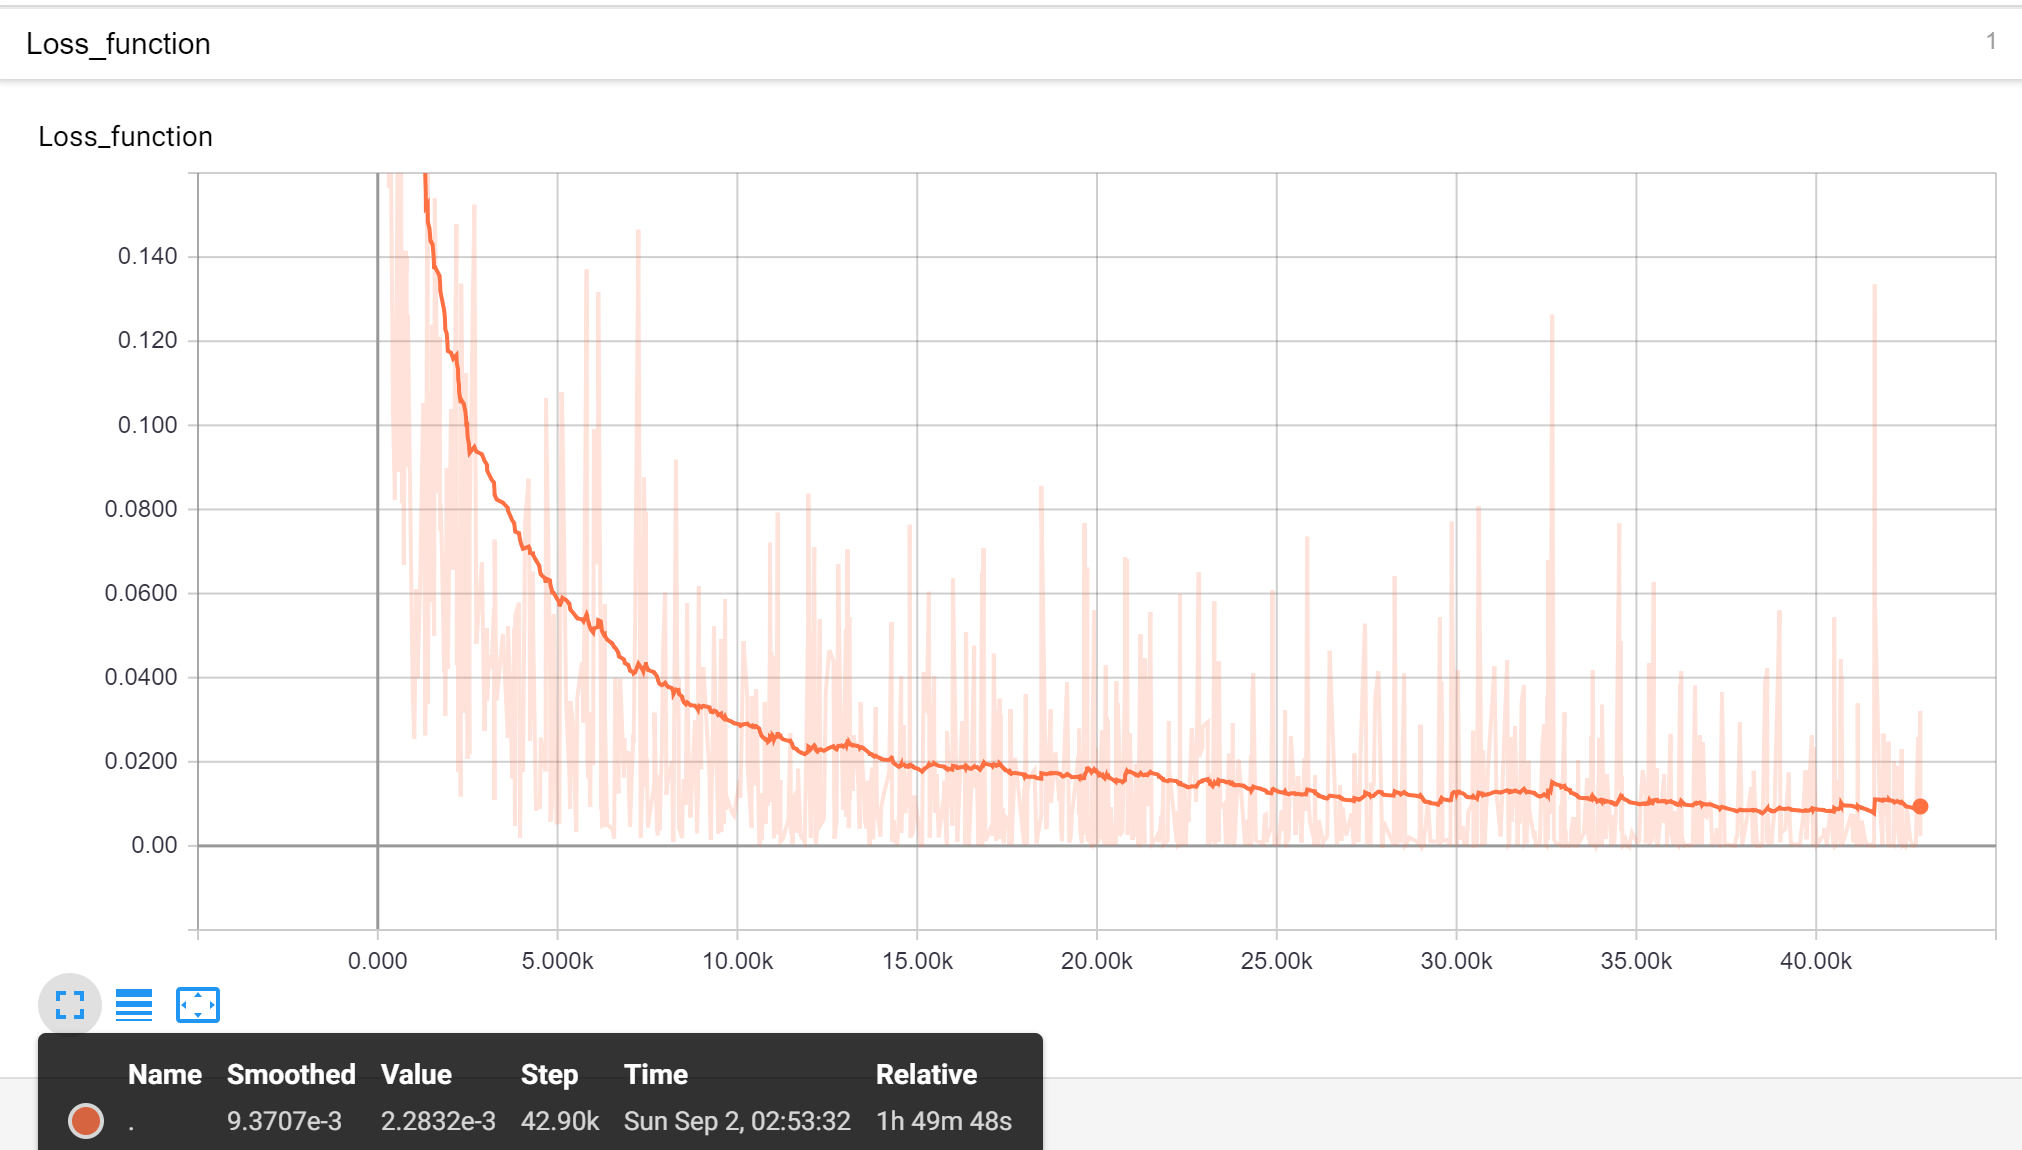

In [220]:
from IPython.display import Image
Image("Loss.PNG")

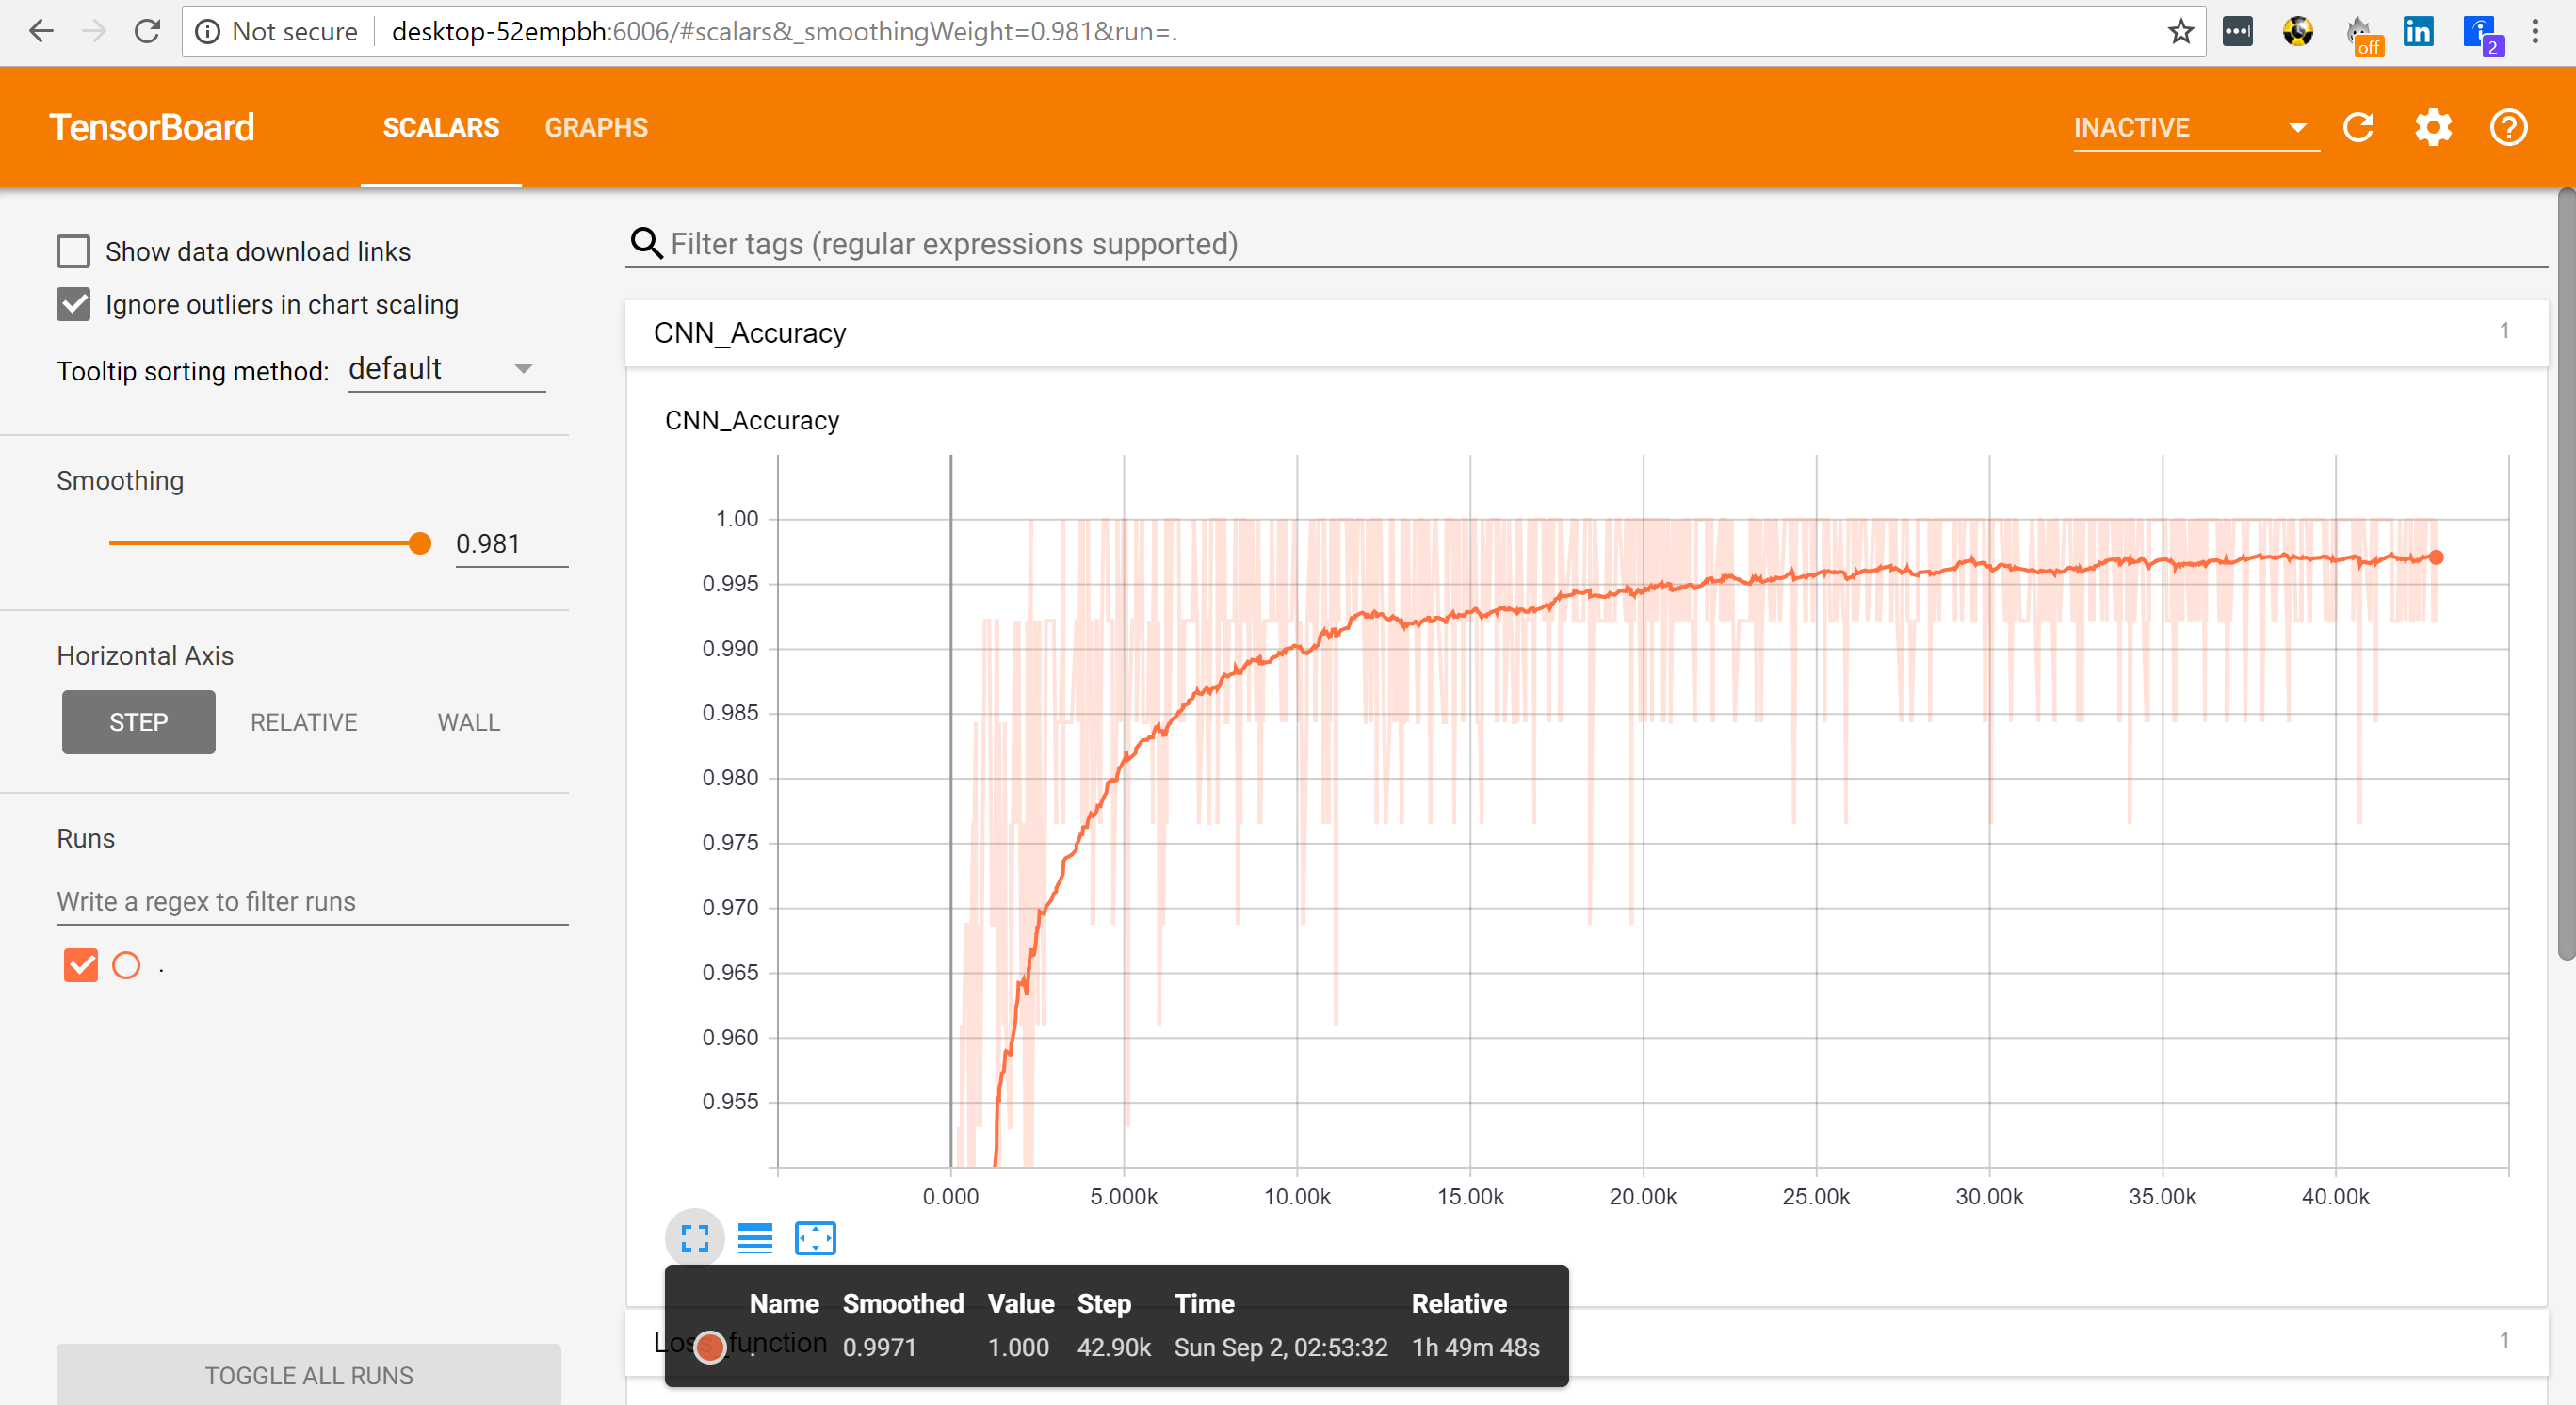

In [221]:
Image("CNN_accuracy.PNG")

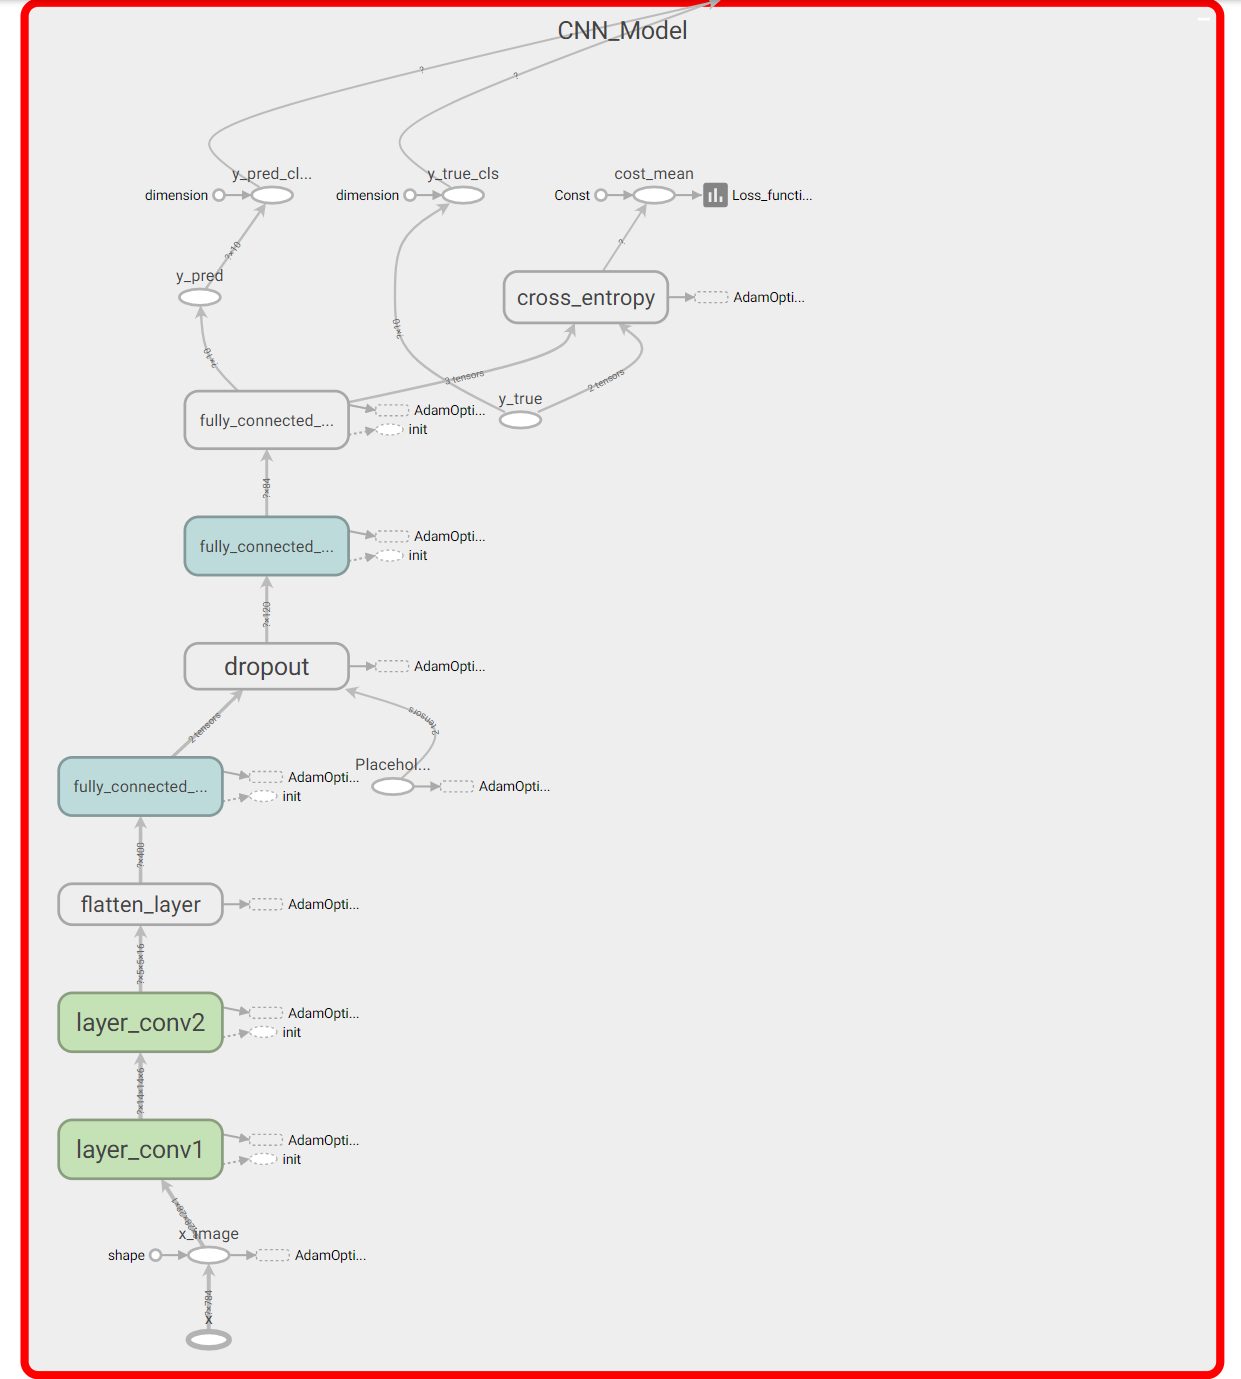

In [222]:
Image("CNN_Architecture.PNG")



<a id='vis'></a>
## VISUALIZING LAYERS

In [193]:
input_image = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='input_image')
x_image = tf.reshape(input_image, [-1, img_size, img_size, num_channels])

In [194]:
#%%pycodestyle
def convolution_layer_plot(layer, image):

    """This is a function for plotting the Convolution Layer"""
    
    # Create a feed-dict containing just one image.
    feed_dict = {input_image: [image]}

    # Initialize the session
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Calculate and retrieve the output values of the layer
    # when image is given as input.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the convolution layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(int(num_filters/num_grids), num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # 4-dim tensor.
            img = values[0, :, :, i]

            # Plotting the image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Removing ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [195]:
#%%pycodestyle

def convolution_weights_plot(weights, input_channel=0):

    """This is a function for plotting the convolution weights"""
    
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Retrieving the weights
    w = sess.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the convolution layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(int(num_filters/num_grids), num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plotting image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Removing ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

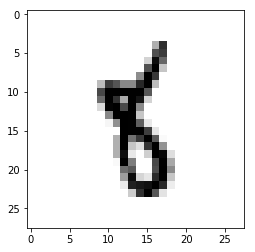

In [198]:
#%%pycodestyle

def plot_image(image):
    """ This is a function to plot an image"""
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()
    
# Sample image
image1 = mnist.test.images[5678]
plot_image(image1)

<a id='l1'></a>
## LAYER 1

In [199]:
layer_conv01, weights_conv01 = convolution_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                    name_weights='weigh',
                    name_biases='biases',
                    name_layer='layer')

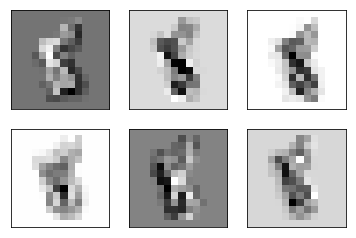

In [200]:
convolution_layer_plot(layer_conv01,image1)

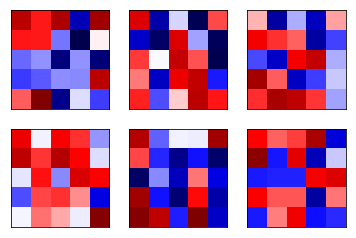

In [201]:
convolution_weights_plot(weights_conv01)

<a id='l2'></a>
## LAYER 2

In [202]:
layer_conv02, weights_conv02 = \
    convolution_layer(input=layer_conv01,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                    name_weights='weigh',
                    name_biases='biases',
                    name_layer='layer')

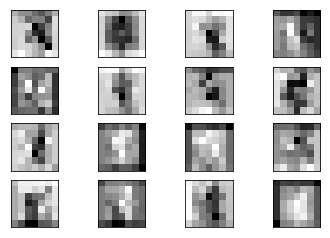

In [203]:
convolution_layer_plot(layer_conv02,image1)

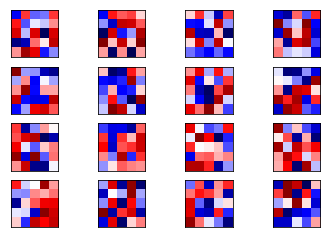

In [204]:
convolution_weights_plot(weights_conv02)

<a id='prob'></a>
## Problems Faced



> 1) Very Slow to run. It took me about 2hrs to run the code on full training data. My computer doesn't have a GPU so that's a problem.

> 2) CNN is not invariant to rotation and scale. They do not encode the position and orientation of the object into their predictions.

> 3) Selecting an appropriate learning rate to get accuracy over 99%.

> 4) Selecting the architecture of CNN.

> 5) I see overfitting even though I change any measure and changing the model itself. It might be because at first I added 4 convolution layers and a maxpool layer without dropout. After adding dropout I see reduction in overfitting and increased accuracy.

<a id='how'></a>

## How to Overcome them:-

> 1) Using Cloud Instances like AWS, Azure, GCP.

> 2) Using Capusle Networks over CNNs. Data Augmentation can also be done.

> 3) Sanity Check or Cross Validation for selecting learning rate

> 4) Implement modern tenchiques fron architectures of recent papers like alexnet etc.,